# Deep Learning with TensorFlow/Keras

Now that we have completed a project of Machine Learning with spark ML, in this assignment, we will be swithing to the context of Deep Learning with Tensorflow/Keras by two tasks:
- Task1: Image Classification with CNN
- Task2: Image captioning with a combination of CNN and RNN

## Task 1: Going Deeper with convolutions


Before **Inception v1** (**GoogLeNet**), which is the winner of the **ILSVRC** (ImageNet Large Scale Visual Recognition Competition) in 2014, most popular CNNs just stacked convolution layers deeper and deeper, hoping to get better performance.
The Inception network, however, uses a lot of tricks to improve performance in terms of speed and accuracy.
Compared to other networks, **Inception v1** has significant improvement over **ZFNet** (the winner in 2013) and **AlexNet** (the winner in 2012), and has relatively lower error rate compared with the VGGNet.

In this task, we will be implementing the inception architecture [in this paper](https://arxiv.org/abs/1409.4842) with TensorFlow/Keras. 

The goal of this task is to understand how to write code to build the model, as long as you can verify the correctness of the code (e.g., through Keras model summary), it is not necessary to train the model.

In [1]:
import os
from tensorflow import keras
import numpy as np
import math

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint

In [2]:
num_classes        = 10
batch_size         = 64         # 64 or 32 or other
epochs             = 300
iterations         = 782       
USE_BN=True
LRN2D_NORM = True
DROPOUT=0.4
CONCAT_AXIS=3
WEIGHT_DECAY=1e-4
DATA_FORMAT='channels_last' # Theano:'channels_first' Tensorflow:'channels_last'

log_filepath  = './inception_v1'
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

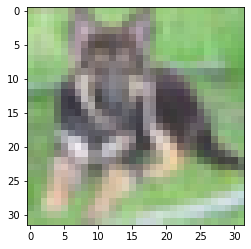

In [3]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plt.imshow(x_train[156])

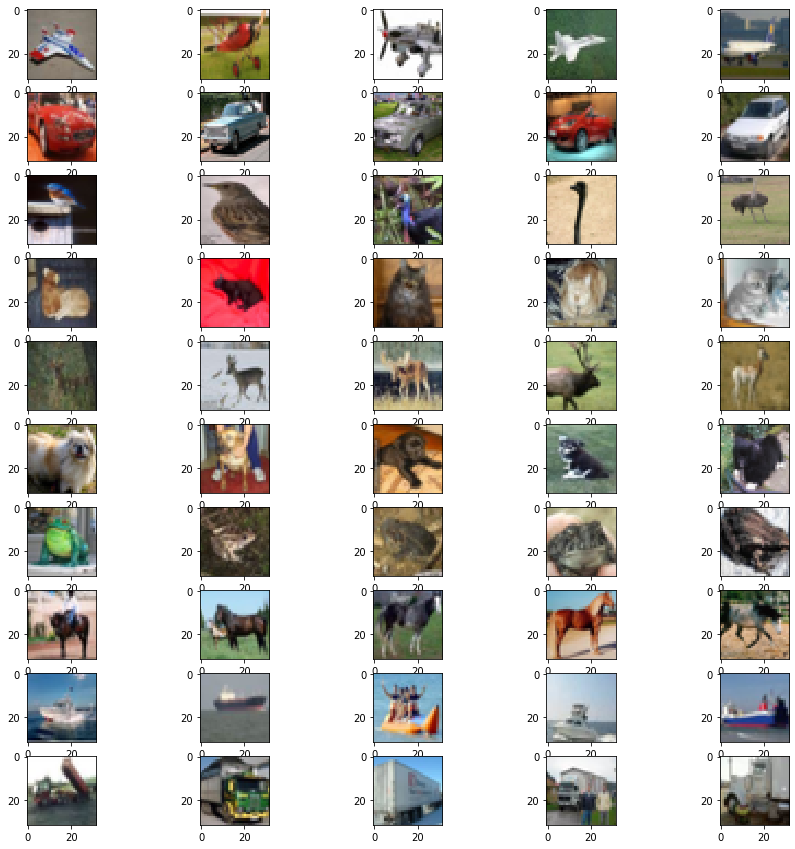

In [4]:
for i in range(1,11):
    index = np.where(y_train == i-1 )[0]
    for j in range(1,6):
        plt.figure(1, figsize=(15,15))
        plt.subplot( 10,5,(i-1)*5+j )
        plt.imshow(x_train[index[j]]  )
        
plt.show()
    

In [5]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

In [6]:
def inception_module(x, nf1,nf2,nf3,nf4):
    
    branch1 = Conv2D( filters= nf1 , kernel_size=(1,1),strides=1,padding="same", activation="relu")(x)

    branch2 = Conv2D( filters= nf2[0] , kernel_size=(1,1),strides=1,padding="same", activation="relu")(x)
    branch2 = Conv2D( filters= nf2[1] , kernel_size=(3,3),strides=1,padding="same", activation="relu")(branch2)

    branch3 = Conv2D( filters= nf3[0] , kernel_size=(1,1),strides=1,padding="same", activation="relu")(x)
    branch3 = Conv2D( filters= nf3[1] , kernel_size=(5,5),strides=1,padding="same", activation="relu")(branch3)

    branch4 = MaxPooling2D(pool_size=(3,3),strides=1,padding="same")(x)
    branch4 = Conv2D(filters= nf4,kernel_size=(1,1),strides=1,padding="same", activation="relu" )(branch4)

    concatenation = concatenate([branch1,branch2,branch3,branch4])
    
    return concatenation

def create_model(input_image):

    x = Conv2D( filters= 64 , kernel_size=(7,7),strides=2,padding="same", activation="relu")(input_image)
    x = MaxPooling2D( pool_size=(3,3),strides=2,padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=64,kernel_size=(1,1),strides=1,padding='same',activation='relu')(x)
    x = Conv2D(filters=192,kernel_size=(3,3),strides=1,padding='same',activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D( pool_size=(3,3),strides=2,padding='same')(x)

    x = inception_module(x,nf1 =64, nf2= (96,128), nf3 = (16,32), nf4=32   )
    x = inception_module(x,nf1 =128, nf2= (128,192), nf3 = (32,96), nf4=64   )
    x = MaxPooling2D( pool_size=(3,3),strides=2,padding='same')(x)

    x = inception_module(x,nf1 =192, nf2= (96,208), nf3 = (16,48), nf4=64   )
    x = inception_module(x,nf1 =160, nf2= (112,224), nf3 = (24,64), nf4=64   )
    x = inception_module(x,nf1 =128, nf2= (128,256), nf3 = (24,64), nf4=64   )
    x = inception_module(x,nf1 =112, nf2= (144,288), nf3 = (32,64), nf4=64   )
    x = inception_module(x,nf1 =256, nf2= (160,320), nf3 = (32,128), nf4=128   )
    x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)

    x = inception_module(x,nf1 =256, nf2= (160,320), nf3 = (32,128), nf4=128   )
    x = inception_module(x,nf1 =384, nf2= (192,384), nf3 = (48,128), nf4=128   )
    x = AveragePooling2D(pool_size=(1,1),strides=1,padding="valid")(x)

    x=Flatten()(x)
    x=Dropout(DROPOUT)(x)

    x=Dense(units=num_classes,activation='linear')(x)
    x=Dense(units=num_classes,activation='softmax')(x)
    
    return x

def scheduler(epoch):
    #if epoch < 150:
    #    return 0.1
    #if epoch < 225:
    #    return 0.01
    return 0.01

In [7]:
img_input=Input(shape=(32,32,3))
output = create_model(img_input)

model=Model(img_input,output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 64)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 8, 8, 64)     256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
x_train = x_train/255
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
#datagen.fit(x_train)

In [ ]:
x_train = x_train*255

In [ ]:
# set optimizer
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set callback
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
cbks = [change_lr,tb_cb]

In [ ]:
model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))

## Task 2: Show and Tell: A Neural Image Caption Generator

Automatically describing the content of an image is a fundamental problem in AI that connects *computer vision* and *natural language processing*.
In this task, we will be looking into how we can use CNNs and RNNs to build an Image Caption Generator.

Specifically, you will be implementing and training the model [in this paper](https://arxiv.org/abs/1411.4555) with TensorFlow/Keras on one of the datasets mentioned in the paper.

To lighten the burden on training the network, you can use any pretrained network in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

In [8]:
# A Data class that handles basically everything
from ClassUtils import Data

Using TensorFlow backend.


python 3.7.5 (default, Oct 31 2019, 15:18:51) [MSC v.1916 64 bit (AMD64)]
keras version 2.2.4-tf
tensorflow version 2.0.0



#### Analyze text data
- Word token distribution shows that the text data is dominated by punctuations and single letter words, as well as some instances of words appearing twice because of capital letters, some preprocessing has to be done.

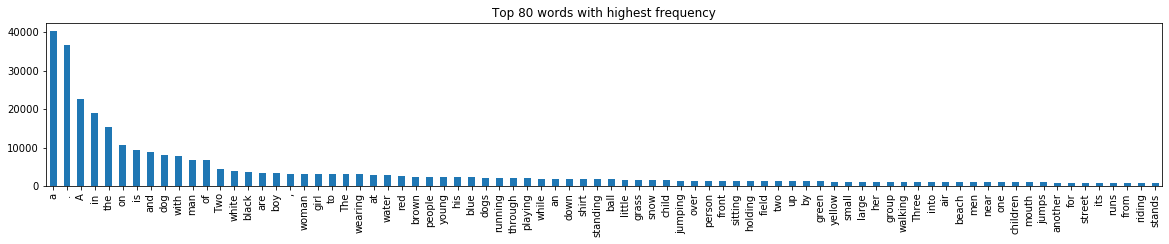

 Number of unique images: 8091

 Number of unique word tokens: 9631

3625049113_554d82c2a1.jpg
----------------------------------------------------------------------------------------------------
1: A man on inline-skates at a skate park
----------------------------------------------------------------------------------------------------
2: A man rollerblading on a ramp
----------------------------------------------------------------------------------------------------
3: A rollerblader is performing a trick on a ramp .
----------------------------------------------------------------------------------------------------
4: A young man does tricks on a ramp .
----------------------------------------------------------------------------------------------------
5: Fisheye view of a man in Rollerblades grinding at the top of a ramp .
----------------------------------------------------------------------------------------------------


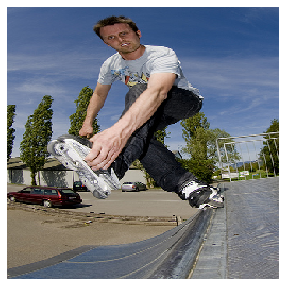

In [9]:
data = Data()
data.fill_text_df("Dataset/Flickr_8k_Text/Flickr8k.token.txt")
data.plot_word_dist(count = 80)
data.get_info()
data.show_random_img_example()

#### Preprocessing
 - remove punctuation
 - remove capital letters
 - remove single letter words
 - remove numericals
 - add start word and stop word for each caption
 - Tokenize
 
 Inspect the new distribution of words.

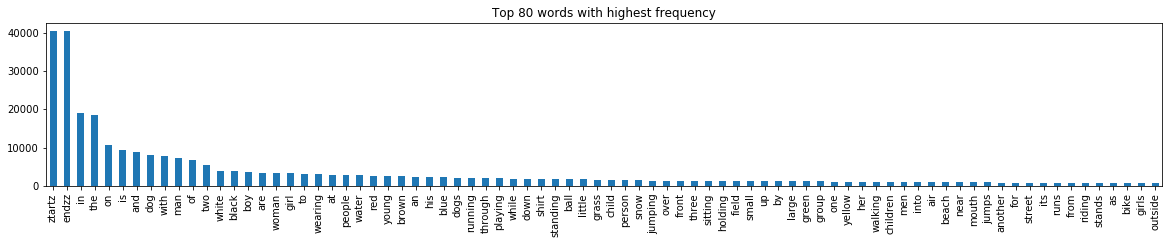

 Number of unique images: 8091

 Number of unique word tokens: 8771

408573233_1fff966798.jpg
----------------------------------------------------------------------------------------------------
1: ztartz black and brown dog in grassy welllit area with his mouth partially open endzz
----------------------------------------------------------------------------------------------------
2: ztartz dog running fast with his ears flying endzz
----------------------------------------------------------------------------------------------------
3: ztartz black and brown dog with mouth open upright on green grass endzz
----------------------------------------------------------------------------------------------------
4: ztartz the black and brown dog is running on the grass endzz
----------------------------------------------------------------------------------------------------
5: ztartz the black and brown dog is running with something in its mouth endzz
----------------------------------------

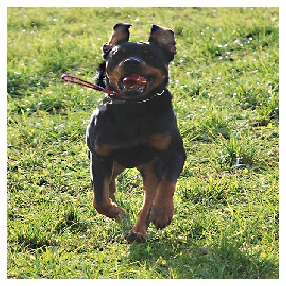

In [10]:
data.clean_text()
data.wrap_captions()
data.fit_tokenizer()
data.plot_word_dist(count = 80)
data.get_info()
data.show_random_img_example()
data.max_caption_length = data.get_max_length() # Used later for padding

## Model

#### Load densenet201 ([link to paper](https://arxiv.org/pdf/1608.06993.pdf)) as a pretrained model, no need for top layer since we only need the feature extraction.

DenseNet-201 is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is 201 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.

#### Load pretrained model

In [11]:
data.load_pretrained_img_embedder()

#### Extract features

In [12]:
data.generate_and_store_features("Dataset/Flickr_8k_Images/")

Features already stored in pickle, loading them instead


#### Split data into train, validation & test then shuffle

In [13]:
from sklearn.model_selection import train_test_split

# These fractions forced the partitions to not overlap image wize
train, test = train_test_split(data.df, shuffle = False, test_size=0.13)
train, validation = train_test_split(train, shuffle = False, test_size=0.15)

#### Define combined Model

In [14]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, concatenate
from tensorflow.keras import Model

embedding_size = 300

image_input = Input(shape=(1920,))
image_model_1 = Dropout(0.3)(image_input)
image_model = Dense(embedding_size, activation='relu')(image_model_1)

caption_input = Input(shape=(data.max_caption_length,))
caption_model_1 = Embedding(data.vocab_size, embedding_size, mask_zero=True)(caption_input)
caption_model_2 = Dropout(0.3)(caption_model_1)
caption_model = LSTM(256)(caption_model_2)

final_model_1 = concatenate([image_model, caption_model])
final_model_2 = Dense(256, activation='relu')(final_model_1)
final_model = Dense(data.vocab_size, activation='softmax')(final_model_2)

model = Model(inputs=[image_input, caption_input], outputs=final_model)
model.compile(loss='categorical_crossentropy', optimizer='adam')

#### Train model

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 64
trainGen = data.data_generator(train, batch_size)
valiGen = data.data_generator(validation, batch_size)

steps_train = len(train)//batch_size
steps_val = len(validation)//batch_size
epochs = 5
epochs_to_wait_for_improve = 2

model_save_path = "Models/batchSize_" + str(batch_size) + "_epochs_" + str(epochs) + "_withZeros2.h5"

early_stopping_callback = EarlyStopping(monitor='val_loss', patience = epochs_to_wait_for_improve)
mc = ModelCheckpoint(model_save_path, monitor = 'val_loss', mode = 'min', verbose=1, save_best_only = True)

callbacks = [mc, early_stopping_callback]

model = model.fit_generator(
            trainGen,
            epochs=epochs,
            steps_per_epoch=steps_train,
            validation_data=valiGen,
            validation_steps=steps_val,
            callbacks=callbacks,
            verbose=1)

Epoch 1/5
466/467 [============================>.] - ETA: 1s - loss: 4.9405
Epoch 00001: val_loss improved from inf to 4.45946, saving model to Models/batchSize_64_epochs_5_withZeros2.h5
467/467 [==============================] - 652s 1s/step - loss: 4.9387 - val_loss: 4.4595
Epoch 2/5
466/467 [============================>.] - ETA: 2s - loss: 3.9334
Epoch 00002: val_loss improved from 4.45946 to 4.18196, saving model to Models/batchSize_64_epochs_5_withZeros2.h5
467/467 [==============================] - 1296s 3s/step - loss: 3.9332 - val_loss: 4.1820
Epoch 3/5
466/467 [============================>.] - ETA: 1s - loss: 3.5740
Epoch 00003: val_loss improved from 4.18196 to 4.08079, saving model to Models/batchSize_64_epochs_5_withZeros2.h5
467/467 [==============================] - 906s 2s/step - loss: 3.5735 - val_loss: 4.0808
Epoch 4/5
466/467 [============================>.] - ETA: 0s - loss: 3.3396
Epoch 00004: val_loss improved from 4.08079 to 4.05187, saving model to Models/batch

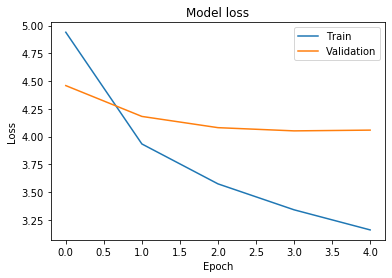

In [11]:
import matplotlib.pyplot as plt
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### Load a trained model

In [15]:
import tensorflow as tf
from random import randint
saved_model = tf.keras.models.load_model('Models/batchSize_64_epochs_5.h5')

#### Look at the result

ztartz two boys in field endzz


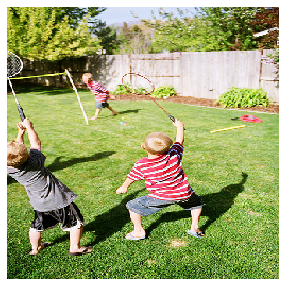

In [18]:
img = list(test.filename)[randint(0,len(test))]
data.show_img(img)
print(data.generate_caption(saved_model, data.features[img]))